In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', message='pkg_resources is deprecated')
warnings.filterwarnings('ignore', message='Data has no positive values')

import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
import mre_pinn

torch.cuda.is_available()

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


PINN training will work normally. Only FEM baseline comparisons are disabled.


False

Download the BIOQIC simulation data set and convert it to xarray format.

In [3]:
bioqic = mre_pinn.data.BIOQICFEMBox('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/fem_box')

File already exists at ..\data\BIOQIC\downloads\four_target_phantom.mat, skipping download
Use force=True to re-download
Loading ..\data\BIOQIC\downloads\four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
<xarray.Dataset> Size: 23MB
Dimensions:    (frequency: 6, x: 80, y: 100, z: 10, component: 3)
Coordinates:
  * frequency  (frequency) int32 24B 50 60 70 80 90 100
  * x          (x) float64 640B 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y          (y) float64 800B 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
  * z          (z) float64 80B 0.0 0.001 0.002 0.003 ... 0.006 0.007 0.008 0.009
  * component  (component) <U1 12B 'y' 'x' 'z'
Data variables:
    wave       (frequency, x, y, z, component) complex128 23MB (0.00180392876...
Segmenting spatial regions
Creating ground truth elastogram
Writing ..\data\BIOQIC\fem_box\50\wave.nc
Writing ..\data\BIOQ

Visualize the wave field and display spatial metadata and descriptive statistics. Note that the z component of the wave field has the highest displacement amplitude. You can view the different components by adjusting the component slider.

Loading ..\data\BIOQIC\fem_box\90\wave.nc
Loading ..\data\BIOQIC\fem_box\90\mre.nc
Loading ..\data\BIOQIC\fem_box\90\mre_mask.nc


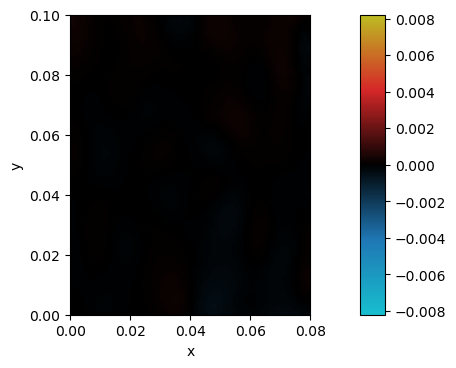

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [4]:
frequency = 90 # Hz
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', frequency)
example.view('wave', ax_height=3)

In [5]:
example.metadata

size  spacing  \
variable dimension                  
wave     x            80    0.001   
         y           100    0.001   
         z            10    0.001   
mre      x            80    0.001   
         y           100    0.001   
         z            10    0.001   
mre_mask x            80    0.001   
         y           100    0.001   
         z            10    0.001   

                                                               origin  \
variable dimension                                                      
wave     x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.)\...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.)\...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.)\...   
mre      x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.)\...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.)\...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.)\...   
mre_mask x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.)\...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.)\...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.)\...   

                                                                limit  \
variable dimension                                                      
wave     x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.07...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.09...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   
mre      x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.07...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.09...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   
mre_mask x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.07...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.09...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   

                                                               center  \
variable dimension                                                      
wave     x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   
mre      x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   
mre_mask x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   

                                                               extent  
variable dimension                                                     
wave     x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.08...  
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.1)...  
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.01...  
mre      x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.08...  
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.1)...  
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.01...  
mre_mask x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.08...  
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.1)...  
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.01...

In [6]:
example.describe()

dtype    count                      mean  \
variable component                                                  
wave     y          complex128  80000.0    -0.000001-   0.000005j   
         x          complex128  80000.0     0.000079-   0.000073j   
         z          complex128  80000.0    -0.000287-   0.000249j   
mre      scalar     complex128  80000.0  3382.375000+ 565.486678j   
mre_mask scalar          int32  80000.0     1.076500+   0.000000j   

                            std                       min  \
variable component                                          
wave     y             0.000241    -0.000499-   0.000196j   
         x             0.000346    -0.000905+   0.000477j   
         z             0.004918    -0.011268-   0.002122j   
mre      scalar     1590.727619  3000.000000+ 565.486678j   
mre_mask scalar        0.362143     1.000000+   0.000000j   

                                         25%  \
variable component                             
wave     y            -0.000058+   0.000031j   
         x            -0.000015-   0.000234j   
         z            -0.002060-   0.001419j   
mre      scalar     3000.000000+ 565.486678j   
mre_mask scalar        1.000000+   0.000000j   

                                                               50%  \
variable component                                                   
wave     y         -2.027842e-06+1.385699e-                    07j   
         x          6.278027e-05+1.562524e-                    05j   
         z         -7.380324e-12-7.602312e-                    11j   
mre      scalar     3.000000e+03+5.654867e+                    02j   
mre_mask scalar     1.000000e+00+0.000000e+                    00j   

                                         75%                         max  
variable component                                                        
wave     y             0.000062-   0.000136j      0.000474+    0.000099j  
         x             0.000169-   0.000225j      0.001094-    0.000011j  
         z             0.001818-   0.001513j      0.008730+    0.001950j  
mre      scalar     3000.000000+ 565.486678j  10000.000000+  565.486678j  
mre_mask scalar        1.000000+   0.000000j      5.000000+    0.000000j

Visualize ground truth elasticity map along with AHI and FEM-based elasticity reconstruction methods.

Evaluating direct baseline


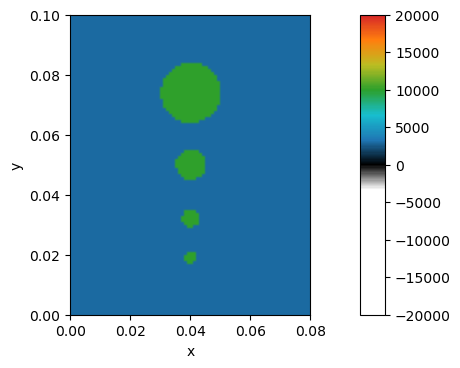

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

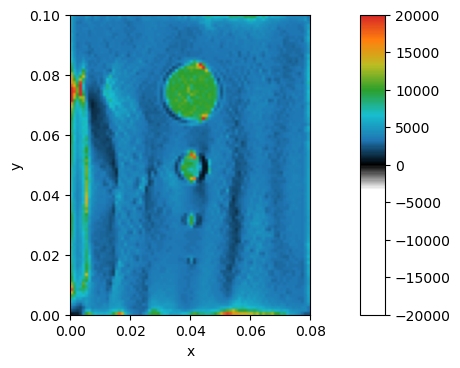

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [7]:
mre_pinn.baseline.eval_ahi_baseline(example, frequency=frequency)
#mre_pinn.baseline.eval_fem_baseline(example, frequency=frequency, hetero=False)
example.view('mre', 'direct', ax_height=3, polar=True, vmax=20e3)

Construct the PDE and PINN architecture that will be used to solve it.

In [8]:
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=frequency)

In [9]:
# Check what's in the metadata
print(example.metadata['center'])
print(type(example.metadata['center'].wave.values))
print(example.metadata['center'].wave.values)

variable  dimension
wave      x            <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...
          y            <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...
          z            <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...
mre       x            <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...
          y            <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...
          z            <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...
mre_mask  x            <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...
          y            <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...
          z            <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...
Lu        x            <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...
          y            <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...
          z            <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...
direct    x            <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...
          y            <xarray.

In [10]:
pinn = mre_pinn.model.MREPINN(
    example,
    omega=60,
    n_layers=2,
    n_hidden=64,
    activ_fn='ss', # sin
    polar_input=False
)
pinn

c:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\model\pinn.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.u_loc = torch.tensor(stats['mean'].loc['wave'])
c:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\model\pinn.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.u_scale = torch.tensor(stats['std'].loc['wave'])
c:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\model\pinn.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beh

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=64, bias=True)
    (output): Linear(in_features=67, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=64, bias=True)
    (output): Linear(in_features=67, out_features=2, bias=True)
  )
)

Compile the PINN model and specify training hyperparameters.

In [11]:
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 0, 1e-8],
    pde_warmup_iters=1000,   # Reduced from 10000 for CPU (10% of original)
    pde_step_iters=500,      # Reduced from 5000 for CPU (10% of original)
    pde_step_factor=10,      # Keep same - controls how fast PDE weight grows
    pde_init_weight=1e-12,   # Smaller initial weight for more gradual ramp-up
    n_points=1024,           # Reduced from 4096 for CPU (25% of original)
    device = 'cpu'
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000332 s



Perform model forward-backward pass benchmarking to estimate training time.

In [12]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(10)

# iterations: 10
Data time/iter:  0.0079s (5.86%)
Model time/iter: 0.0036s (2.66%)
Loss time/iter:  0.1240s (91.48%)
Total time/iter: 0.1356s
Total time: 1.3560s
1k iters time: 2.26m
10k iters time: 22.60m
100k iters time: 3.77h


Create test evaluator that will be used to periodically evaluate and visualize model output on full spatial domain. The visualizers should update automatically once the training loop begins. Note that the interactive sliders can be used to adjust what slice of the images are visualized, but these do not work while the training loop is running.

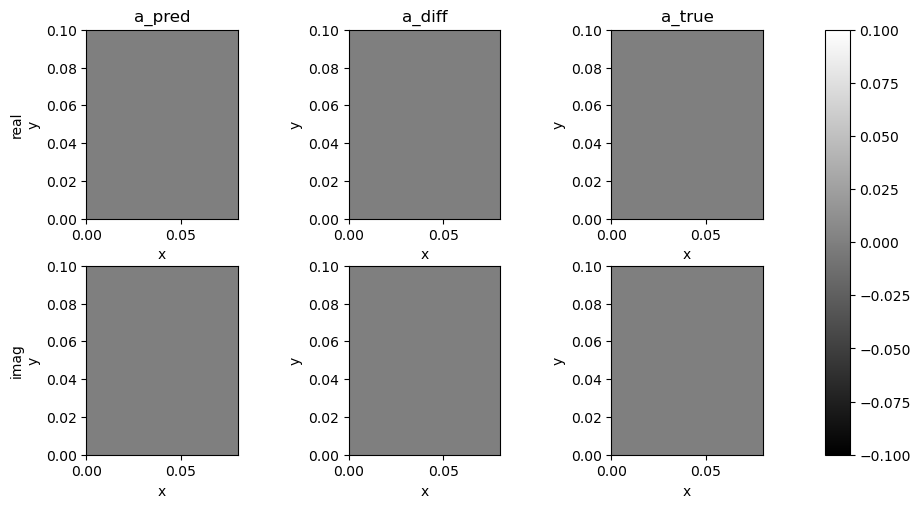

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

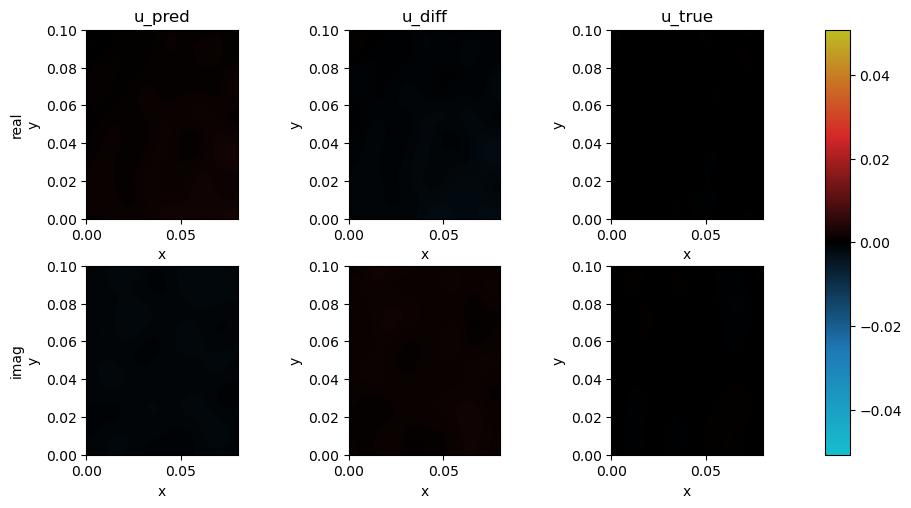

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

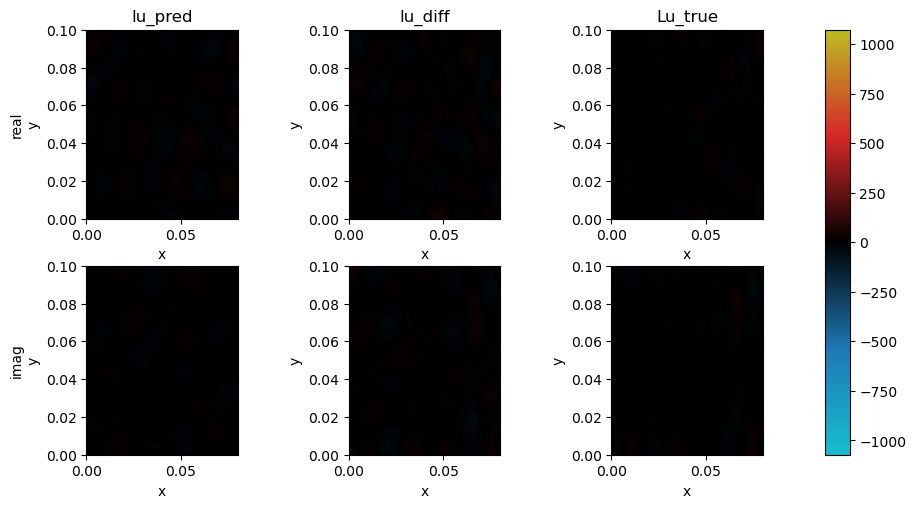

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

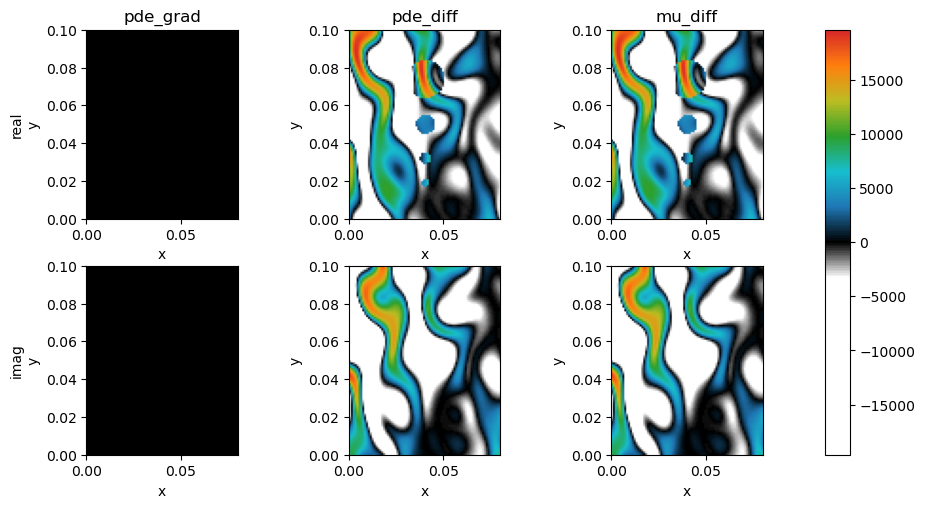

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

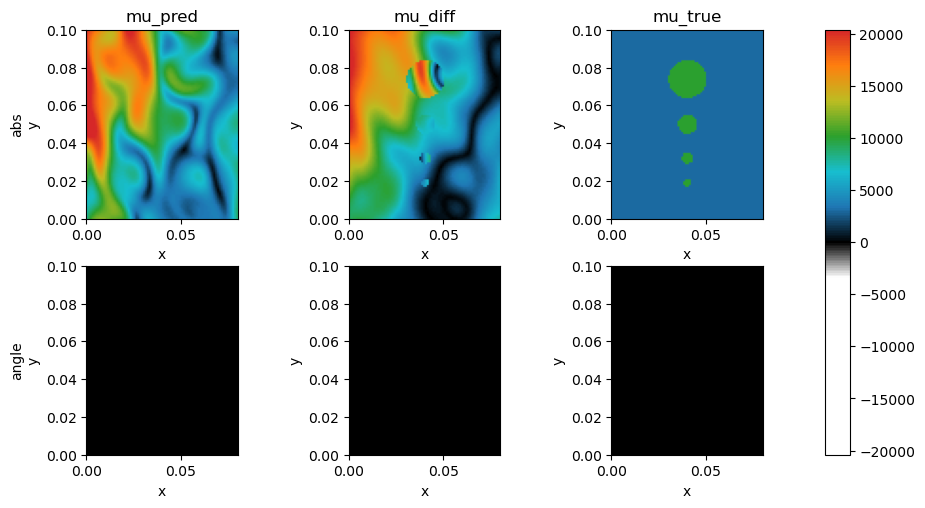

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

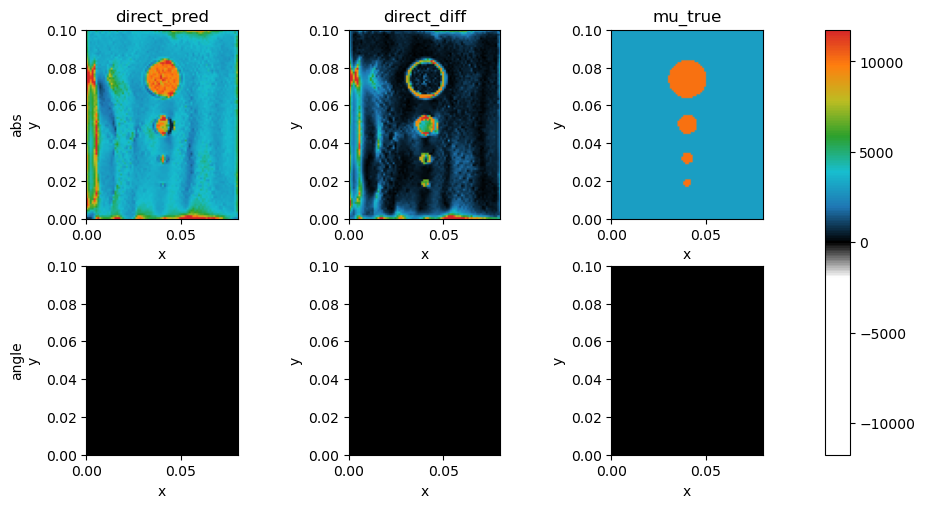

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [19]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=1000, save_every=1000, save_prefix='DEMO', interact=True)
test_eval.model = model
test_eval.test()

Run the training loop.

In [20]:
# Create a progress tracking callback
from tqdm.auto import tqdm
import deepxde

class ProgressCallback(deepxde.callbacks.Callback):
    def __init__(self, total_iters):
        super().__init__()
        self.pbar = None
        self.total_iters = total_iters
        
    def on_train_begin(self):
        self.pbar = tqdm(total=self.total_iters, desc="Training", unit="iter")
        
    def on_epoch_end(self):
        if self.pbar is not None:
            self.pbar.n = self.model.train_state.step
            self.pbar.refresh()
        
    def on_train_end(self):
        if self.pbar is not None:
            self.pbar.close()

progress_callback = ProgressCallback(5000)

In [24]:
%%time
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
model.train(500, display_every=500, callbacks=[test_eval, progress_callback], disregard_previous_best=True)
if torch.cuda.is_available():
    print(f"Peak GPU memory: {torch.cuda.max_memory_allocated() / 2**30:.2f} GiB")
else:
    print("CUDA not available - memory stats not tracked")

Training model...

Step      Train loss                                  Test loss                                   Test metric
5400      [3.41e-06, 0.00e+00, 0.00e+00, 7.88e+02]    [3.19e-06, 0.00e+00, 0.00e+00, 8.62e+02]    []  


Training:   0%|          | 0/5000 [00:00<?, ?iter/s]

5500      [3.32e-06, 0.00e+00, 0.00e+00, 8.32e+02]    [3.12e-06, 0.00e+00, 0.00e+00, 8.19e+02]    []  
5900      [2.86e-06, 0.00e+00, 0.00e+00, 6.28e+02]    [2.69e-06, 0.00e+00, 0.00e+00, 6.20e+02]    []  

Best model at step 5900:
  train loss: 6.28e+02
  test loss: 6.20e+02
  test metric: []

'train' took 47.073173 s

CUDA not available - memory stats not tracked
CPU times: total: 1min 19s
Wall time: 47.1 s


In [22]:
test_eval.test()

In [23]:
test_eval.metrics

MSAV  \
iteration dataset variable_type variable_source variable_name spatial_frequency_bin spatial_region                                                      
400       train   anatomy       model           a_pred        all                   all             <xarray.DataArray 'anatomy' ()> Size: 8B\narra...   
                                                              1.0                   all                                                           NaN   
                                                              2.0                   all                                                           NaN   
                                                              3.0                   all                                                           NaN   
                                                              4.0                   all                                                           NaN   
...                                                                                                                                               ...   
5400      train   direct        reference       mu_true       all                   1                                                             NaN   
                                                                                    2                                                             NaN   
                                                                                    3                                                             NaN   
                                                                                    4                                                             NaN   
                                                                                    5                                                             NaN   

                                                                                                    PSD  \
iteration dataset variable_type variable_source variable_name spatial_frequency_bin spatial_region        
400       train   anatomy       model           a_pred        all                   all             NaN   
                                                              1.0                   all             NaN   
                                                              2.0                   all             0.0   
                                                              3.0                   all             0.0   
                                                              4.0                   all             0.0   
...                                                                                                 ...   
5400      train   direct        reference       mu_true       all                   1               NaN   
                                                                                    2               NaN   
                                                                                    3               NaN   
                                                                                    4               NaN   
                                                                                    5               NaN   

                                                                                                             MAV  \
iteration dataset variable_type variable_source variable_name spatial_frequency_bin spatial_region                 
400       train   anatomy       model           a_pred        all                   all                      NaN   
                                                              1.0                   all                      NaN   
                                                              2.0                   all                      NaN   
                                                              3.0                   all                      NaN   
                                                              4.0  